In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import math
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from random import *
from sklearn.model_selection import KFold, cross_val_score

import os
import subprocess

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
in_file = 'data.csv'
data = pd.read_csv(in_file, sep=';')

# Print the first few entries data
display(data.head())

,nu_analise,nu_unidade,nu_origem,nu_unidade_ocorrencia,cd_situacao,ic_21,ic_211,ic_212,ic_22,ic_23,...,ic_293,ic_210,ic_51,ic_52a,ic_52b,ic_52c,ic_52d,ic_52e,ic_52f,ic_52g
0,1,85,3,85,4,2,0,0,2,1,...,0,2,2,0,0,1,0,0,0,0
1,1,289,8,289,4,2,0,0,2,2,...,0,1,2,0,0,0,1,0,0,0
2,1,478,3,478,4,2,0,0,2,2,...,1,2,2,0,0,0,0,0,0,1
3,1,759,4,759,4,1,2,0,3,3,...,1,1,2,0,0,1,0,0,0,1
4,1,1027,3,1027,4,2,0,0,2,3,...,0,2,2,0,0,1,1,0,0,0


In [2]:
data = data[data.cd_situacao != 1]
data = data[data.cd_situacao != 2]
data = data[data.cd_situacao != 9]

# TODO: Total number of records
n_records = data.nu_analise.count()

# TODO: Number of records where individual's income is more than $50,000
granted = data[(data['cd_situacao']==3)].cd_situacao.count()

# TODO: Number of records where individual's income is at most $50,000
declined = data[(data['cd_situacao']==4)].cd_situacao.count()

# TODO: Percentage of individuals whose income is more than $50,000
granted_percent = (float(granted)/n_records)*100

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Analysis that became disciplinary process {}".format(granted))
print ("Analysis archived: {}".format(declined))
print ("Percentage of disciplinary process admitted: {:.2f}%".format(granted_percent))


Total number of records: 54899
Analysis that became disciplinary process 5984
Analysis archived: 48915
Percentage of disciplinary process admitted: 10.90%


In [3]:
# Store the 'cd_situacao' feature in a new variable and remove it from the dataset
data = data.drop(['nu_analise', 'nu_unidade', 'nu_unidade_ocorrencia', 'ic_21', 'ic_211', 'ic_212', 'ic_284', 'nu_2841_valor'], axis = 1)
data = data.drop(['ic_51', 'ic_52a', 'ic_52b', 'ic_52c', 'ic_52d', 'ic_52e', 'ic_52f', 'ic_52g'], axis = 1)
data = data.dropna(axis=0)
outcomes = data['cd_situacao']
data = data.drop('cd_situacao', axis = 1)

outcomes = outcomes.apply(lambda x: 1 if x == 3 else 0)

In [4]:
# Show the new dataset with features removed
display(data.head())
data_summary = data[['nu_283_total', 'nu_283_res']].describe()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(data_summary)

,nu_origem,ic_22,ic_23,ic_231,ic_24,ic_25,ic_26,ic_27,ic_28,ic_281,...,nu_283_res,ic_29,ic_291_prestador,ic_291_estagiario,ic_291_menor,ic_291_outrosPF,ic_291_PJ,ic_291_naoIndicado,ic_293,ic_210
0,3,2,1,1,2,0,0,0,1,2,...,0.00,2,0,0,0,0,0,0,0,2
1,8,2,2,2,2,0,0,0,1,2,...,0.00,2,0,0,0,0,0,0,0,1
2,3,2,2,2,1,2,3,2,1,2,...,3407.44,1,0,0,0,0,0,1,1,2
3,4,3,3,3,3,2,1,3,1,2,...,0.00,1,0,0,0,1,0,0,1,1
4,3,2,3,3,2,0,0,0,1,2,...,0.00,2,0,0,0,0,0,0,0,2


,nu_283_total,nu_283_res
count,54899.00,54899.00
mean,63979.93,4368.25
std,1019804.91,227158.10
min,0.00,0.00
25%,236.06,0.00
50%,4597.09,0.00
75%,16315.23,0.00
max,135073856.00,34885571.12


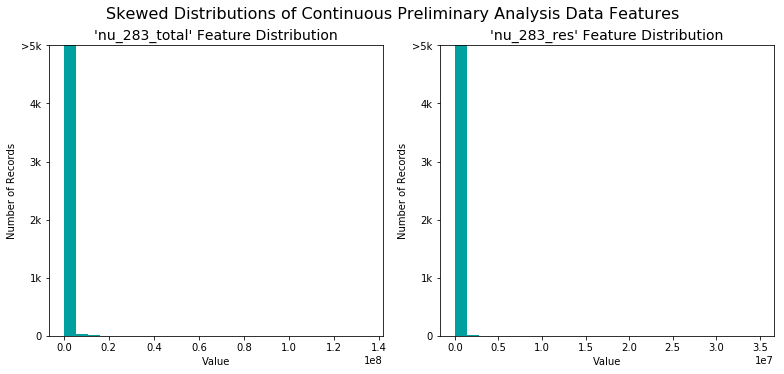

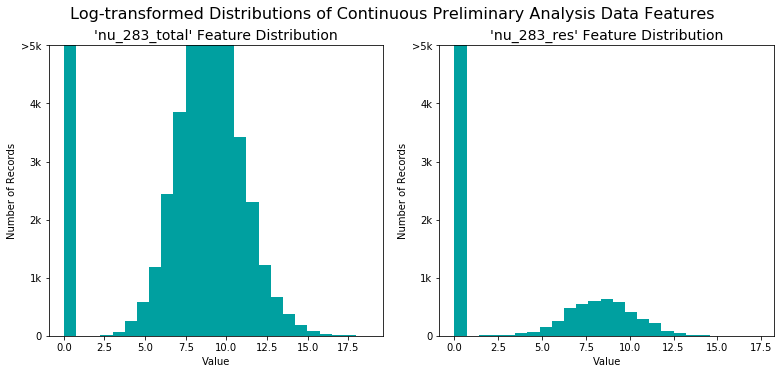

In [5]:
# Visualize skewed continuous features of original data
vs.distribution(data)

features_raw = data

# Log-transform the skewed features
skewed = ['nu_283_total', 'nu_283_res']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

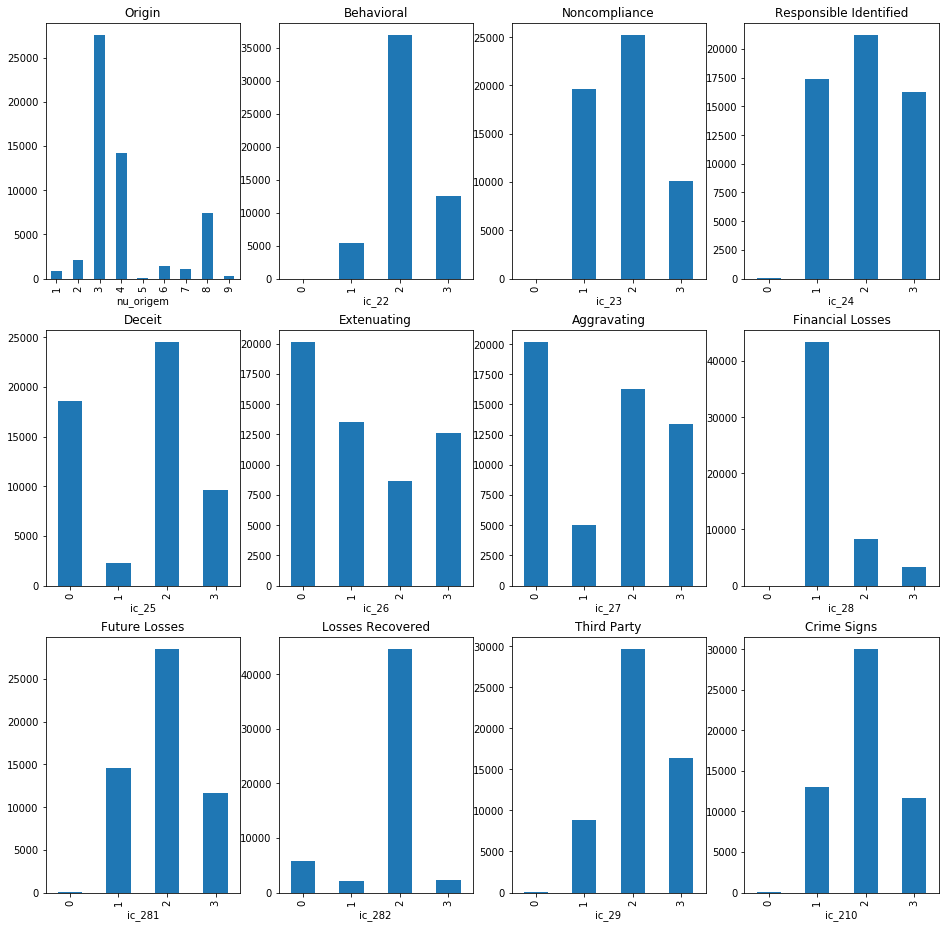

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,16))
data.groupby(['nu_origem']).size().plot(ax=axes[0,0], kind='bar'); axes[0,0].set_title('Origin')
data.groupby(['ic_22']).size().plot(ax=axes[0,1], kind='bar'); axes[0,1].set_title('Behavioral')
data.groupby(['ic_23']).size().plot(ax=axes[0,2], kind='bar'); axes[0,2].set_title('Noncompliance')
data.groupby(['ic_24']).size().plot(ax=axes[0,3], kind='bar'); axes[0,3].set_title('Responsible Identified')
data.groupby(['ic_25']).size().plot(ax=axes[1,0], kind='bar'); axes[1,0].set_title('Deceit')
data.groupby(['ic_26']).size().plot(ax=axes[1,1], kind='bar'); axes[1,1].set_title('Extenuating')
data.groupby(['ic_27']).size().plot(ax=axes[1,2], kind='bar'); axes[1,2].set_title('Aggravating')
data.groupby(['ic_28']).size().plot(ax=axes[1,3], kind='bar'); axes[1,3].set_title('Financial Losses')
data.groupby(['ic_281']).size().plot(ax=axes[2,0], kind='bar'); axes[2,0].set_title('Future Losses')
data.groupby(['ic_282']).size().plot(ax=axes[2,1], kind='bar'); axes[2,1].set_title('Losses Recovered')
data.groupby(['ic_29']).size().plot(ax=axes[2,2], kind='bar'); axes[2,2].set_title('Third Party')
data.groupby(['ic_210']).size().plot(ax=axes[2,3], kind='bar'); axes[2,3].set_title('Crime Signs')

In [7]:
# Import train_test_split
"""
CODE CHANGES
------------

The sklearn.cross_validation has been deprecated 
and the classes and functions have been reorganized 
into the sklearn.model_selection.
The original line has been commented below.

More info: http://scikit-learn.org/stable/whats_new.html
"""
# from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[:40000], outcomes[:40000], test_size = 0.25, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 30000 samples.
Testing set has 10000 samples.


In [8]:
# Make random guesses about the outcomes
outcome_predicted = outcomes.apply(lambda x:randint(0, 1))

# Calculate the true positives
TP=sum(map(lambda x,y: 1 if x==1 and y==1 else 0, outcomes, outcome_predicted))

# Calculate the false positives
FP=sum(map(lambda x,y: 1 if x==0 and y==1 else 0, outcomes, outcome_predicted))

# Calculate the false negatives
FN=sum(map(lambda x,y: 1 if x==1 and y==0 else 0, outcomes, outcome_predicted))

# Calculate accuracy
accuracy = float(TP)/(TP+FP)

# Needed to calculate F-score
recall = float(TP)/(TP+FN)

# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
fscore = (1+beta**2)*((accuracy*recall)/(beta**2*accuracy+recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.1108, F-score: 0.1313]


In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set,
    # then get predictions on the first 3000 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:3000])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 3000 training samples
    results['acc_train'] = accuracy_score(y_train[:3000],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 3000 training samples
    results['f_train'] = fbeta_score(y_train[:3000],predictions_train,beta=0.5, average='weighted')
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5, average='weighted')
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

GradientBoostingClassifier trained on 300 samples.
GradientBoostingClassifier trained on 3000 samples.
GradientBoostingClassifier trained on 30000 samples.
LogisticRegression trained on 300 samples.
LogisticRegression trained on 3000 samples.
LogisticRegression trained on 30000 samples.
AdaBoostClassifier trained on 300 samples.
AdaBoostClassifier trained on 3000 samples.
AdaBoostClassifier trained on 30000 samples.


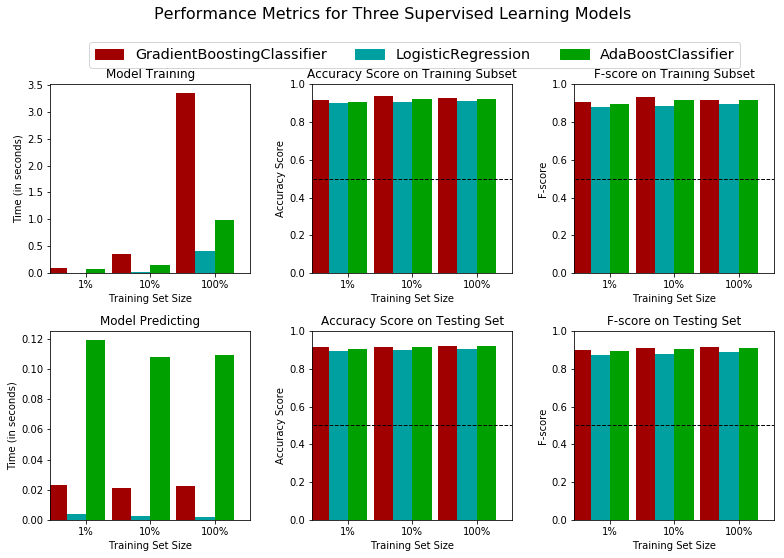

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = GradientBoostingClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = math.ceil(len(X_train)/100)
samples_10 = math.ceil(len(X_train)/10)
samples_100 = math.ceil(len(X_train)/1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, 0.5, 0.5)

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=0)

# Create the parameters list you wish to tune
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average='weighted')))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}\n".format(fbeta_score(y_test, best_predictions, beta = 0.5, average='weighted')))
print (best_clf)
results = grid_fit.cv_results_
print ("\n")
# print (results)

Unoptimized model
------
Accuracy score on testing data: 0.9026
F-score on testing data: 0.8866

Optimized Model
------
Final accuracy score on the testing data: 0.9023
Final F-score on the testing data: 0.8863

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)




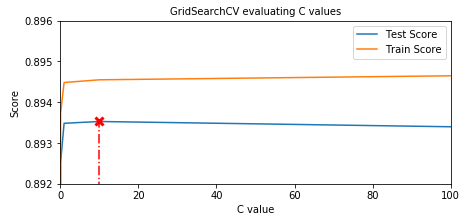

In [12]:
plt.figure(figsize=(7, 3))
plt.title("GridSearchCV evaluating C values",
          fontsize=10)

plt.xlabel("C value")
plt.ylabel("Score")
plt.grid()

y_values = results['mean_test_score']
y2_values = results['mean_train_score']
x_values = np.array(results['param_C'].data, dtype=float)

ax = plt.axes()
ax.set_xlim(0, 100)
ax.set_ylim(0.892, 0.896)
ax.plot(x_values, y_values, label='Test Score')
ax.plot(x_values, y2_values, label='Train Score')
best_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
best_score = results['mean_test_score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([x_values[best_index], ] * 2, [0, best_score],
        linestyle='-.', color='r', marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (x_values[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

[ 0.89294302  0.89416055  0.89584365  0.89223794  0.89331121]
[ 0.90834861  0.90816667  0.91083333  0.90766667  0.90898483]


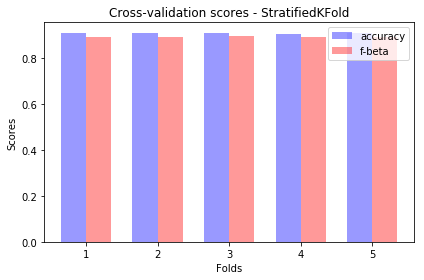

In [13]:
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(C=10)

fbeta_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer)
accuracy_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
print(fbeta_cv)
print(accuracy_cv)

n_groups = 5

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, accuracy_cv, bar_width,
                 alpha=opacity,
                 color='b',
                 label='accuracy')

rects2 = plt.bar(index + bar_width, fbeta_cv, bar_width,
                 alpha=opacity,
                 color='r',
                 label='f-beta')

plt.xlabel('Folds')
plt.ylabel('Scores')
plt.title('Cross-validation scores - StratifiedKFold')
plt.xticks(index + bar_width / 2, ('1', '2', '3', '4', '5'))
plt.legend()

plt.tight_layout()
plt.show()

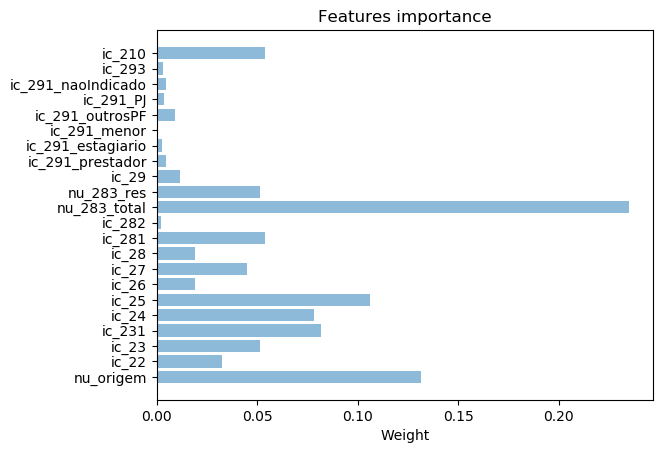

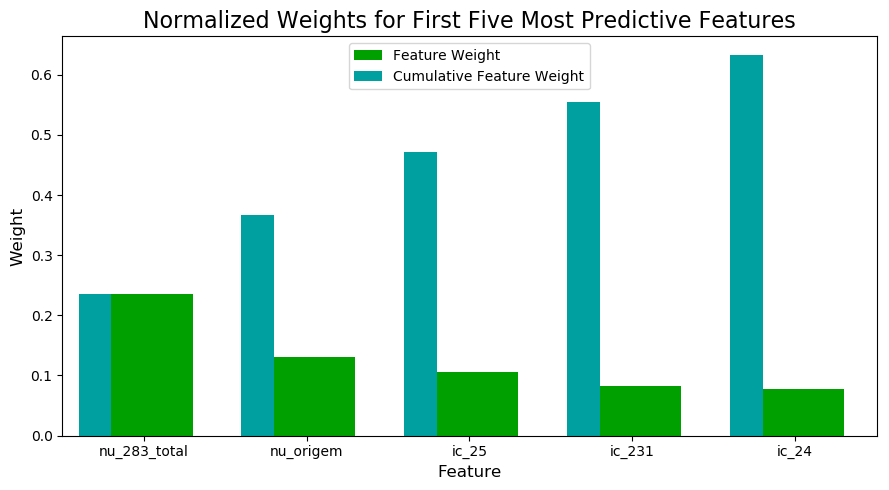

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

model = GradientBoostingClassifier(random_state=0)

model.fit(X_train, y_train)
 
objects = data.columns
y_pos = np.arange(len(objects))
weights = model.feature_importances_
 
plt.barh(y_pos, weights, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Weight')
plt.title('Features importance')
 
plt.show()


# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [15]:
"""
Reading test batch
"""
df = pd.read_csv('test_data.csv', sep=';')
df = df.head()
df

,cd_analise,nu_origem,ic_22,ic_23,ic_231,ic_24,ic_25,ic_26,ic_27,ic_28,...,nu_283_res,ic_29,ic_291_prestador,ic_291_estagiario,ic_291_menor,ic_291_outrosPF,ic_291_PJ,ic_291_naoIndicado,ic_293,ic_210
0,81653,6,2,1,3,1,3,3,3,3,...,0.00,3,0,0,0,0,0,0,0,1
1,84856,9,2,1,1,1,3,2,1,1,...,0.00,1,1,0,0,0,0,0,1,1
2,84922,9,2,1,1,1,2,3,3,1,...,0.00,1,0,0,0,1,0,0,3,2
3,85145,9,2,2,2,2,0,0,0,1,...,0.00,3,0,0,0,0,0,0,0,3
4,85146,9,2,1,1,1,3,2,2,2,...,0.00,2,0,0,0,0,0,0,0,3


In [16]:
analisys_id = df['cd_analise']
df = df.drop('cd_analise', axis = 1)

best_clf.predict(df)

array([0, 1, 1, 1, 1])